## Data Acquisition

In [2]:
from os import listdir
from os.path import isfile, join

import pandas as pd

In [3]:
def merge_dataset(data_files: str = "../datasets", symbol: str = "btc"):
    files = [f for f in listdir(data_files) if isfile(join(data_files, f)) and f.startswith(symbol) and f.endswith('.parquet')]
    return pd.concat(
        pd.read_parquet(join(data_files, f), engine='fastparquet') for f in files
    )

In [4]:
def prepare_dataset(data_files: str = "../datasets", symbol: str = "btc", datetime_index: bool = True):
    df = merge_dataset(data_files=data_files, symbol=symbol)
    
    # timestamp to python datetime
    if datetime_index:
        df['date'] = pd.to_datetime(df['date'], unit='s')

    df = df.set_index(['date'])
    df.sort_index(inplace=True)

    return df

In [4]:
btc_trades_df = prepare_dataset()

In [5]:
btc_trades_df.head()

,type,price,amount
date,,,
2013-06-12 08:39:21,buy,249.0,0.381000
2013-06-12 10:34:30,buy,249.0,0.020000
2013-06-12 16:16:07,buy,249.0,1.387382
2013-06-12 16:16:07,buy,249.0,3.564896
2013-06-12 16:43:47,buy,260.0,0.130480


In [6]:
btc_trades_df.tail()

,type,price,amount
date,,,
2024-03-24 22:47:10,buy,336286.893944,0.000006
2024-03-24 22:47:18,buy,336347.116719,0.000004
2024-03-24 22:47:32,sell,336062.300849,0.000816
2024-03-24 22:47:42,sell,336062.300899,0.000191
2024-03-24 22:47:52,sell,335797.000000,0.000006


In [7]:
btc_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16529676 entries, 2013-06-12 08:39:21 to 2024-03-24 22:47:52
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   type    object 
 1   price   float64
 2   amount  float64
dtypes: float64(2), object(1)
memory usage: 504.4+ MB


In [8]:
btc_trades_df.describe()

,price,amount
count,1.652968e+07,1.652968e+07
mean,1.421893e+05,3.605958e-02
std,1.111363e+05,1.918438e-01
min,0.000000e+00,0.000000e+00
25%,3.781700e+04,7.283800e-04
50%,1.209170e+05,3.506680e-03
75%,2.319979e+05,1.746010e-02
max,3.800000e+05,6.600000e+01


## Exploratory Data Analysis

In [9]:
# TBD

## Models

### Isolation Forest

In [10]:
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [11]:
#initiate the model with 5% contamination

model_year = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination=float(0.05),
    random_state=139,
    n_jobs=-1
)

#### 1 year dataset

In [12]:
df_year = btc_trades_df.loc['2023-01-01':'2023-12-31'][['price', 'amount']]

In [13]:
model_year.fit(df_year)

IsolationForest(contamination=0.05, n_estimators=1000, n_jobs=-1,
                random_state=139)

In [14]:
df_year['score'] = model_year.decision_function(df_year[['price', 'amount']])
df_year['anomaly_value'] = model_year.predict(df_year[['price', 'amount']])

anomaly_value
 1    1218003
-1      64106
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

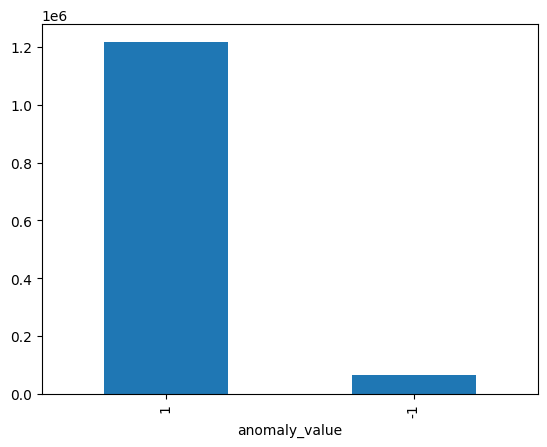

In [15]:
# outliers
outliers_year = df_year.loc[df_year['anomaly_value'] == -1]
outlier_index = list(outliers_year.index)

#datapoints classified -1 are anomalous
print(df_year['anomaly_value'].value_counts())
df_year['anomaly_value'].value_counts().plot(kind = 'bar')

In [16]:
outliers_year

,price,amount,score,anomaly_value
date,,,,
2023-01-01 00:07:22,87967.510750,0.014892,-0.024593,-1
2023-01-01 00:08:02,88198.421493,0.007374,-0.000723,-1
2023-01-01 00:10:51,88184.323920,0.008733,-0.006595,-1
2023-01-01 00:11:28,88181.242159,0.008982,-0.006868,-1
2023-01-01 01:22:32,87972.120050,0.546564,-0.216790,-1
...,...,...,...,...
2023-12-31 22:51:57,209260.000000,0.050840,-0.076820,-1
2023-12-31 22:52:01,208778.385756,0.044911,-0.069223,-1
2023-12-31 22:52:01,208748.701024,0.044913,-0.069223,-1


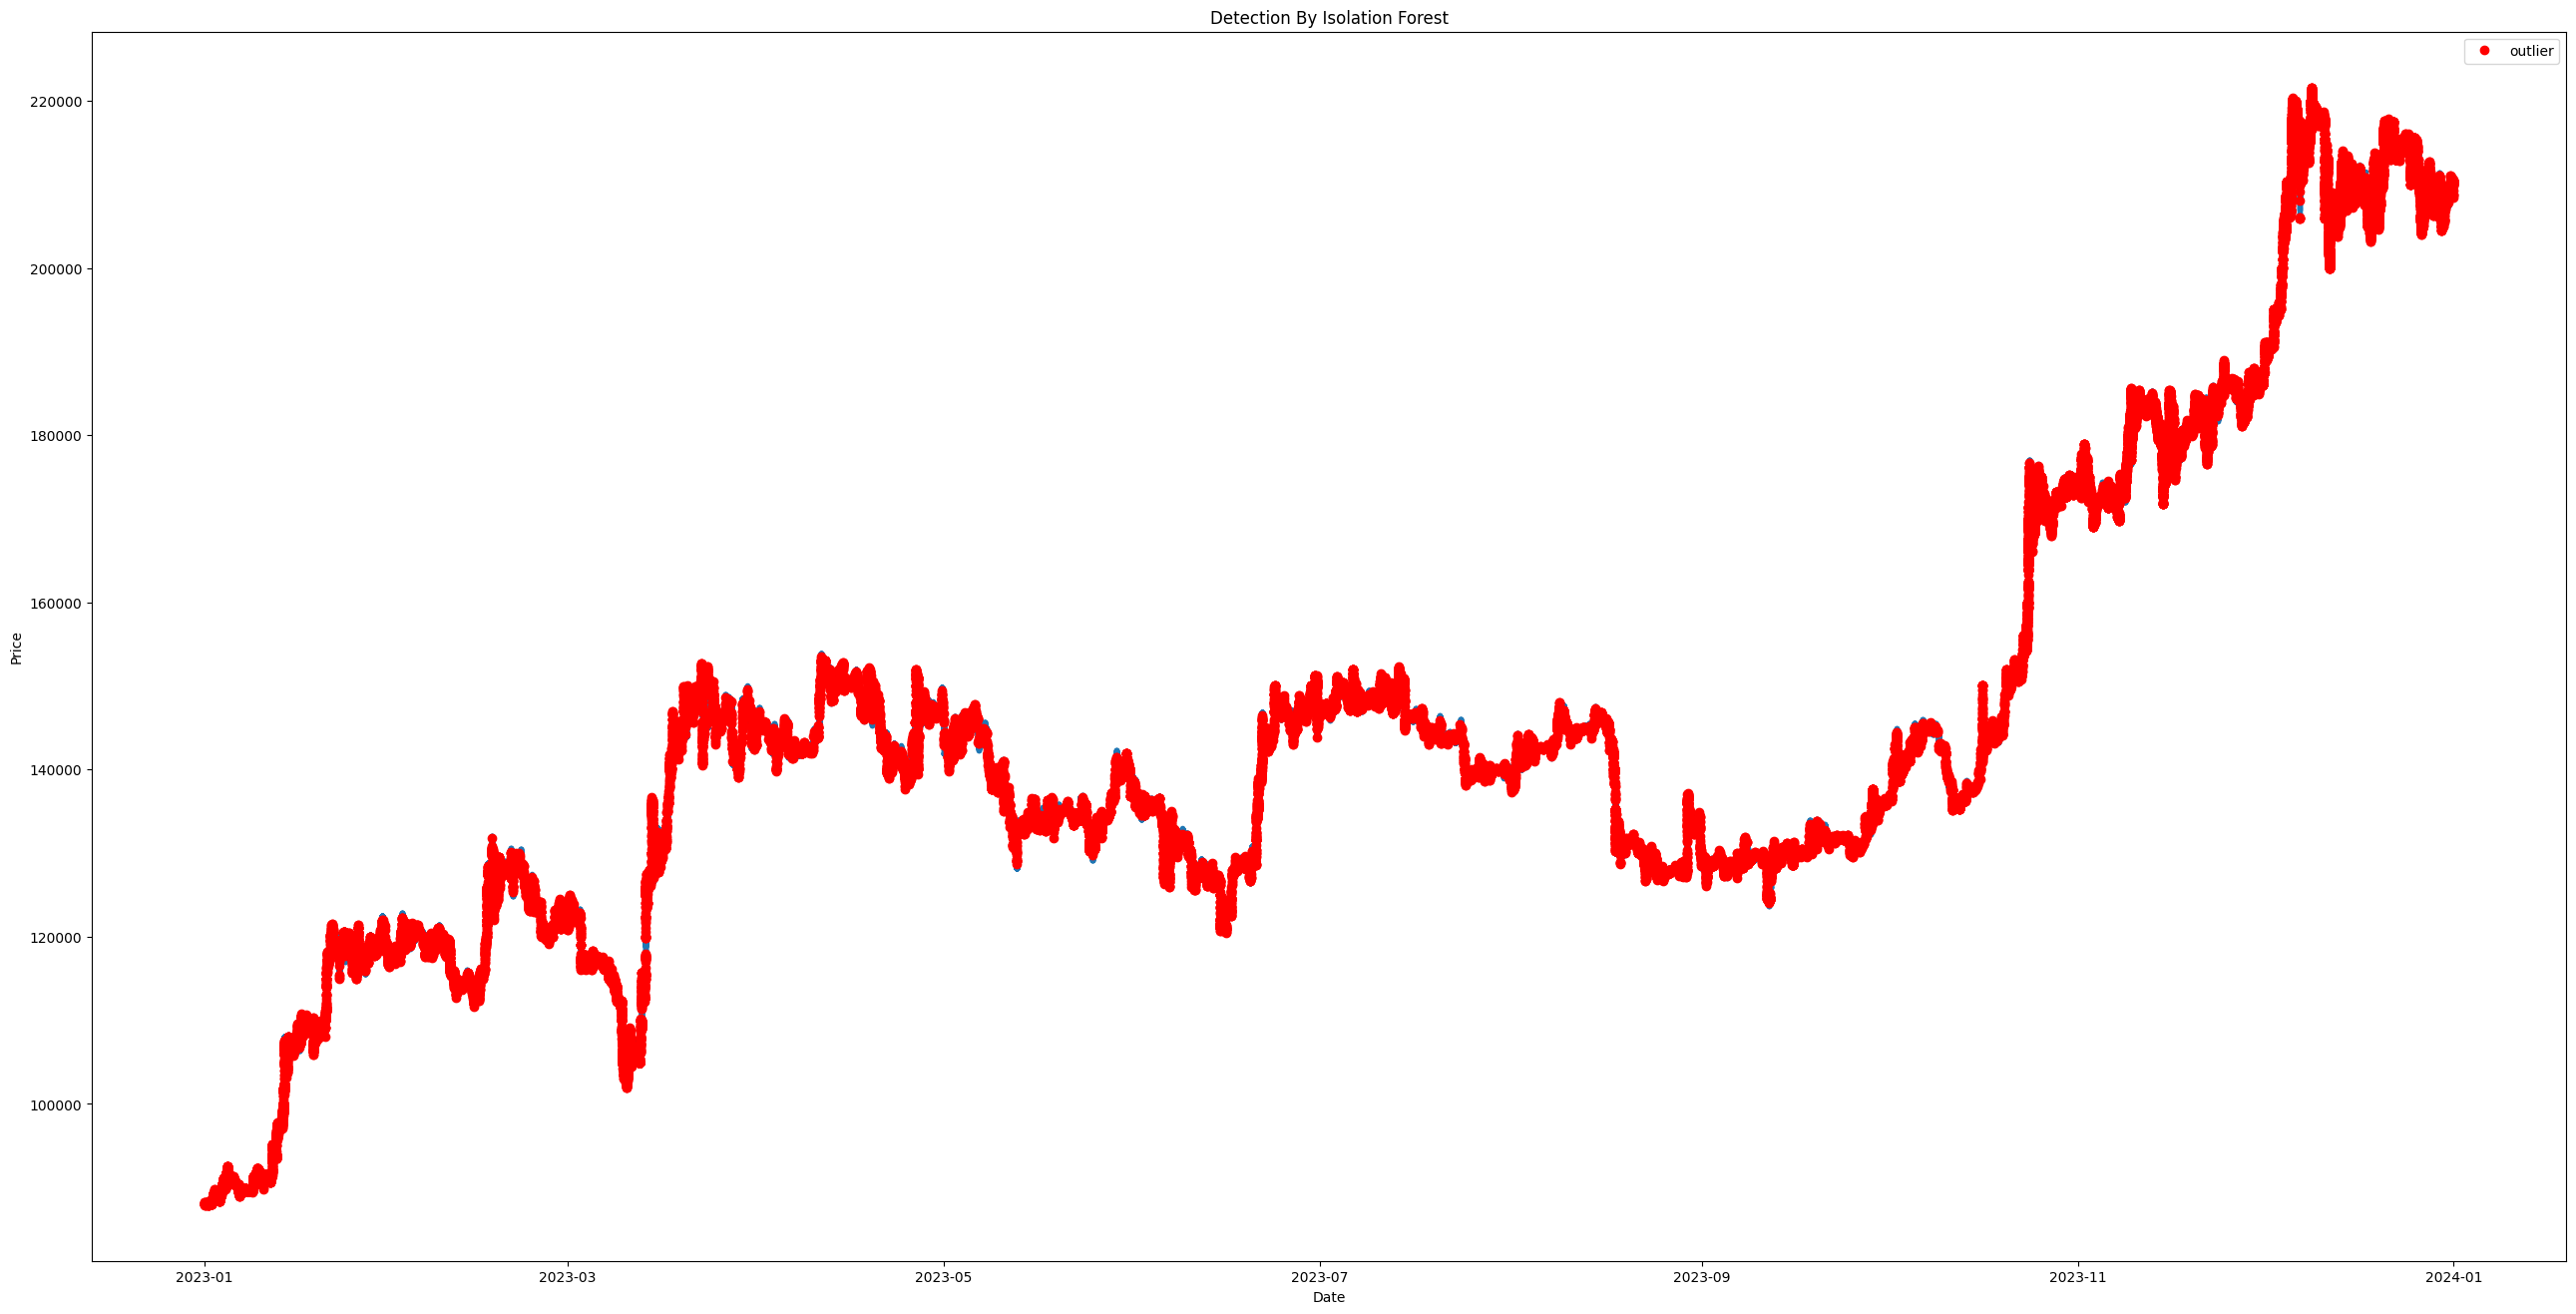

In [17]:
plt.figure(figsize = (32, 16))

plt.plot(df_year[['price']], marker = '.')
plt.plot(outliers_year[['price']], 'o', color = 'red', label = 'outlier')
plt.title('Detection By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [18]:
import plotly.express as px
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# fig = px.line(df_year_2023, x=df_year_2023.index, y="price")
# fig.add_trace(go.Scatter(mode="markers", x=outliers.index, y=outliers["price"], name="outliers"))

#### 1 month dataset

In [ ]:
df_month = btc_trades_df.loc['2024-01-01':'2024-01-31'][['price', 'amount']]

In [ ]:
#initiate the model with 5% contamination

model_month = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination=float(0.05),
    random_state=139,
    n_jobs=-1
)

In [ ]:
model_month.fit(df_month)
df_month['score'] = model_month.decision_function(df_month[['price', 'amount']])
df_month['anomaly_value'] = model_month.predict(df_month[['price', 'amount']])

In [ ]:
# outliers
outliers_month = df_month.loc[df_month['anomaly_value'] == -1]
outlier_index_month = list(outliers_month.index)

#datapoints classified -1 are anomalous
print(df_month['anomaly_value'].value_counts())
df_month['anomaly_value'].value_counts().plot(kind = 'bar')

In [ ]:
outliers_month

In [ ]:
plt.figure(figsize = (32, 16))

plt.plot(df_month[['price']], marker = '.')
plt.plot(outliers_month[['price']], 'o', color = 'red', label = 'outlier')
plt.title('Detection By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

#### 1 day dataset

In [ ]:
df_day = btc_trades_df.loc['2024-03-24':'2024-03-24'][['price', 'amount']]

In [ ]:
df_day

In [ ]:
#initiate the model with 5% contamination

model_day = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination=float(0.05),
    random_state=139,
    n_jobs=-1
)

In [ ]:
model_day.fit(df_day)
df_day['score'] = model_day.decision_function(df_day[['price', 'amount']])
df_day['anomaly_value'] = model_day.predict(df_day[['price', 'amount']])

In [ ]:
# outliers
outliers_day = df_day.loc[df_day['anomaly_value'] == -1]
outlier_index_day = list(outliers_day.index)

#datapoints classified -1 are anomalous
print(df_day['anomaly_value'].value_counts())
df_day['anomaly_value'].value_counts().plot(kind = 'bar')

In [ ]:
outliers_day

In [ ]:
plt.figure(figsize = (32, 16))

plt.plot(df_day[['price']], marker = '.')
plt.plot(outliers_day[['price']], 'o', color = 'red', label = 'outlier')
plt.title('Detection By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

#### 1 hour dataset

In [ ]:
df_hour = btc_trades_df.loc['2024-03-24 17:00:00':'2024-03-24 17:59:59'][['price', 'amount']]

In [ ]:
df_hour

In [ ]:
#initiate the model with 1% contamination

model_hour = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination=float(0.01),
    random_state=139,
    n_jobs=-1
)

In [ ]:
model_hour.fit(df_hour)
df_hour['score'] = model_hour.decision_function(df_hour[['price', 'amount']])
df_hour['anomaly_value'] = model_hour.predict(df_hour[['price', 'amount']])

In [ ]:
# outliers
outliers_hour = df_hour.loc[df_hour['anomaly_value'] == -1]
outlier_index_h = list(outliers_hour.index)

#datapoints classified -1 are anomalous
print(df_hour['anomaly_value'].value_counts())
df_hour['anomaly_value'].value_counts().plot(kind = 'bar')

In [ ]:
outliers_hour

In [ ]:
plt.figure(figsize = (16, 8))

plt.plot(df_hour[['price']], marker = '.')
plt.plot(outliers_hour[['price']], 'o', color = 'red', label = 'outlier')
plt.title('Isolation Forest - Day')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

### Energy-based Flow Classifier (EFC)

In [5]:
# EFC requires discretized data as input


In [6]:
%run efc/usage_example.py

Single-class results
[[  7  36]
 [  0 145]]


/Users/kevinaraujo/repos/dissertation/PPCA-UnB-Dissertation/models/notebooks/efc/generic_discretize.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.iloc[:,feature].fillna(len(intervals[feature]), inplace=True)
/Users/kevinaraujo/repos/dissertation/PPCA-UnB-Dissertation/models/notebooks/efc/generic_discretize.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work

Multi-class results
[[ 0  0 11]
 [ 0  0 48]
 [ 0  0  0]]


In [7]:
from efc.classification_functions import OneClassFit, OneClassPredict, MultiClassFit, MultiClassPredict

In [8]:
btc_trades_df_efc = prepare_dataset()

In [9]:
df_day_efc = btc_trades_df_efc.loc['2024-03-24':'2024-03-24'][['price', 'amount']]

In [10]:
df_day_efc

,price,amount
date,,
2024-03-24 00:00:36,323071.042641,0.000006
2024-03-24 00:01:17,323000.000212,0.001144
2024-03-24 00:02:43,323071.040000,0.000315
2024-03-24 00:02:43,323000.000050,0.030853
2024-03-24 00:02:58,323361.175712,0.000010
...,...,...
2024-03-24 22:47:10,336286.893944,0.000006
2024-03-24 22:47:18,336347.116719,0.000004
2024-03-24 22:47:32,336062.300849,0.000816


In [11]:
# EFC's hyperparameters
Q = df_day_efc.values.max()
LAMBDA = 0.5 # pseudocount parameter

In [13]:
btc_trades_df_efc_np = df_day_efc[['price']].to_numpy(dtype=np.int64)

In [15]:
btc_trades_df_efc_np[0:10]

array([[323071],
       [323000],
       [323071],
       [323000],
       [323361],
       [323000],
       [323093],
       [323890],
       [323816],
       [323912]])

In [ ]:
# train model

coupling, h_i, cutoff, _, _  = OneClassFit(btc_trades_df_efc_np, Q, LAMBDA)